# Predicting the CCRB's Disposition of an Investigation

Daphne Fabella

## Summary of Findings


### Introduction

#### ***The Prediction Problem***: Predict whether the CCRB will Rule an Investigation as Substantiated.
*What's the response variable?*
   - **The CCRB's disposition of an investigation, particularly if it is "Substantiated"**
        - In prior analysis of complaints filed against the NYPD, I conducted a hypothesis test which compared the distribution of CCRB rulings per complainant ethnicity to help answer the question "*Does a complainant's ethnicity influence the CCRB disposition of their allegation?*": the difference between distributions suggested that **complainant ethnicity was not independent from the CCRB disposition of their allegation**. This idea inspired the creation of a binary classifier model that utilitzes patterns within the complaint data to give insight into whether the CCRB will substantiate a complaint case after investigation. This predictive model that can tell whether a case will result in some sort of consequence for the officer under allegation can motivate a more careful, attentive investigation or spark further exploration into why certain complaints are substantiated while others are not.

*What's the metric being used to evaluate the model?*
-  **Recall**
    - False negatives which wrongly classify a case as "Unsubstatiated" underestimates the severity of a complaint, which could possibly frame an investigation as "unnecessary" and lead to the remission of an officer who exhibited disorderly conduct with a civillian. False positives which wrongly classify a case as "Substantiated", however, would incite further invesigation to help guide the CCRB to a fair & just ruling that is more closely reflective of the case's severity. Hence, the consequences of false negatives prove detrimental. Metrics such as accuracy and F1-score also provide insight to how many false classifications are made, but they do not provide insight to the type of false classifications made by the model! However, by using recall as a metric for model evaluation, we can see how many false negatives are made and minimize the number of such wrongly unsubstantiated investigations. 
    
*What features are being used?*  
- All information that would be known at the time of prediction were considered as potential features, while the following were disqualified: 
    - rank_abbrev_now & rank_now
    - command_now 
    - month_closed
    - year_closed  
    
  The officer's rank and command after the investigation closed would not be available before the CCRB makes their final ruling. The month and year a case closes would only be known after the CCRB's disposition is made.
        
### Baseline Model

##### Classifier: Logistic Regression

*What features were used?*
- `rank_incident`the officer's rank at the time of incident (qualitative)
- `mos_ethnicity` the officer's ethnicity (qualitative)
- `complainant_ethnicity` the complainant's ethnicity (qualitative)
- `outcome_description` the outcome of the interaction between the officer and complainant (qualitative)
 
 All of the above were encoded via one-hot encoding using a OneHotEncoder() fitted into a Pipeline object.
 
*Model Performance*
 - Recall: ~42.7%
 - Precision: ~33.3%
 - Accuracy:  ~65.3%
  
  
  **Summary** The model had poor performance, as its low recall signifies a high rate of false negarives, or wrongly unsubstantiated cases and it only classified observations correctly about 65% of the time.  
  *Note: since the data is imbalanced, however, the low accuracy is not as crucial toward model evaluation*

### Final Model

##### Classifier: Logistic Regressor

*What features were added?*
- `contact_reason` reason of interaction between officer and complainant
- `allegation` specific complaint type

 All of the above were encoded via one-hot encoding using a OneHotEncoder() fitted into a Pipeline object.  
 
 I performed a hypothesis test for the reason of interaction between officer and complainant under the motivating question: "Is this information independent from whether a case is substantiated?". The differences between the distributions of `contact_reason` for substantiated and not substantiated cases were statistically significant, suggesting it is likely to be useful in predicting the CCRB's disposition of a given investigation.
 
 For the specific complaint type, I performed exploratory data analysis that resulted in an interesting finding:
 The distribution of CCRB dispositions for the top 5 most common allegations exhibited stark visual differences:
 - of allegations under Physical force, most investigations are Exonerated 
 - of allegations under Word, most investigations are Unsubstantiated
 - of allegations under Stop, most investigations are Substantiated
 - of allegations under Search (of person), most investigations are Unsubstantiated
 - of allegations under Frisk, most investigations are under Sunstantiated  
 
 Under the intuition that complaints filed under specific types are more likely to be substantiated or not substantiated, `allegation` seemed like a useful feature in predicting the CCRB disposition.

*Model Selection*  

 After tuning hyperparameters for three classifiers (LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()), each were fitted to the training data for model evaluation. Each model was compared based on their recall score, and the classifier with the highest recall was selected as the final model.

- Classifier: Logistic Regressor
- Hyperparameters: `C=100`, `max_iter=600`
- Model Selection: `GridSearchCV(scoring='recall')`

*Model Performance*
- Recall: ~54.4% (+11.7%)
- Precision: ~42.5% (+9.2%)
- Accuracy: ~71.2% (+5.9%)

### Fairness Analysis
*What groups were evaluated to assess model fairness?*  
  
 Black complainants make up the largest category of complainants and are typically over-represented in cases of police brutality.  
 Does the model perform differently for Black and non-Black complainants?

*Testing Structure*
- Null Hypothesis: The model is fair. Its recall for Black complainants and non-Black complainants are roughly the same, and any differences are due to random chance.

- Alternative Hypothesis: The model is unfair. Its recall for Black complainants and non-Black complainants are not the same.

- $\alpha =  0.05$

- p-value = 0.51

 *Summary:* Since the p-value is higher than our significance level of 0.05, we fail to reject the null hypothesis which suggests that the model is fair.

## Code

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Baseline Model

In [8]:
cc_fp = os.path.join('data', 'allegations_202007271729.csv')
cc = pd.read_csv(cc_fp)

#### Preprocessing: Cleaning the Data
*Description:* The filed NYPD complaints contains data unsuitable to use as features for our predictive model, so we will filter only for qualifying data; all features must be information that would be available before the CCRB makes its final disposition and they must not cause multicollinearity.  
  
  *Note that all encoding will occur during model development.*

In [140]:
# ------------------------------------
# STEP 1: REMOVE ANY INFORMATION WE WOULD NOT HAVE BEFORE THE CCRB'S FINAL DISPOSITION + ANY MULTICOLLINEARITY
# ------------------------------------
to_remove = ['unique_mos_id', 'shield_no','rank_abbrev_now', 'rank_now', 'rank_abbrev_incident', 
             'command_now','first_name', 'last_name', 'complaint_id', 'board_disposition', 'year_closed', 'month_closed']
features = [feature for feature in cc.columns if feature not in to_remove]

In [10]:
# create a dataframe with ONLY the columns useable as features ( -> 'features dataframe')
cc_features = cc.loc[:, features]

#### Developing the Model

In [12]:
# one-hot encode the CCRB dispositions (1-Substantiated, 0-Not Substantiated)
substantiated = 'Substantiated'
substaniated_dispositions = cc['board_disposition'][cc['board_disposition'].str[:len(substantiated)] == substantiated].unique()
disposition_actual = cc['board_disposition'].replace(['Unsubstantiated', 'Exonerated'], 0).replace(substaniated_dispositions, 1)

##### I. Splitting the Data

In [13]:
# ------------------------------------
# STEP 1: SPLIT INTO TRAINING AND TESTING DATA
# ------------------------------------
from sklearn.model_selection import train_test_split


# training data
X_train = cc_features.sample(frac=0.75, random_state=1)
y_train = disposition_actual[X_train.index]

# testing data (drop nans!)
test_data_ix = [test_data for test_data in cc_features.index if test_data not in X_train.index]
X_test = cc_features.iloc[test_data_ix, :].dropna()
y_test = disposition_actual[X_test.index]

In [14]:
X_train.apply(lambda df: df.isna()).mean() # high proportion of missing values for complainant ethnicity implies need for imputation

month_received              0.000000
year_received               0.000000
command_at_incident         0.045647
rank_incident               0.000000
mos_ethnicity               0.000000
mos_gender                  0.000000
mos_age_incident            0.000000
complainant_ethnicity       0.132704
complainant_gender          0.124550
complainant_age_incident    0.142457
fado_type                   0.000000
allegation                  0.000040
precinct                    0.000919
contact_reason              0.005836
outcome_description         0.001799
dtype: float64

##### II. Imputation

In [15]:
def add_labels(axis, title, x, y):
    '''adds title, x-axis label and y-axis label to plot'''
    axis.set_title(title)
    axis.set_xlabel(x)
    axis.set_ylabel(y)
    return 

In [16]:
def tvd(a, b):
    '''Finds the TVD between the two given distributions'''
    return np.sum(np.abs(a-b)) / 2

In [17]:
# the 'null_compl_ethn' column stores whether the complainant ethnicity is mising 
X_train['null_compl_ethn'] = X_train['complainant_ethnicity'].isna()

# find the number of missing complainant ethnicities within each type of officer ethnicity
ethnicity_missingness = (
    X_train
    .pivot_table(
        index='mos_ethnicity', 
        columns='null_compl_ethn', 
        aggfunc='size')
)

# normalize the number of missing complainant ethnicities 
ethnicity_missingness = (ethnicity_missingness / ethnicity_missingness.sum()).fillna(0)

# find tvd
tvd1 = tvd(ethnicity_missingness[True], ethnicity_missingness[False])
print(f'TVD between the distributions for each officer ethnicity: {tvd1}')

TVD between the distributions for each officer ethnicity: 0.09170866339355023


In [18]:
# -------------------------------------------------------------------------------
# PERMUTATION TEST
# -------------------------------------------------------------------------------
var1_tvds = []

for _ in range(1000):
    # shuffle the missingness of complainant ethnicity
    shuffled_null = (
        X_train['complainant_ethnicity'].isna()
        .sample(frac=1)
        .reset_index(drop=True)
    )

    original_and_shuffled = (
        X_train
        .assign(**{'Shuffled Null' : shuffled_null})
    )

    # find the tvd
    var1_sim = original_and_shuffled.pivot_table(index='mos_ethnicity', columns='Shuffled Null', aggfunc='size')
    var1_sim = (var1_sim / var1_sim.sum()).fillna(0)
    var1_tvd = tvd(var1_sim[True], var1_sim[False])
    var1_tvds.append(var1_tvd)

In [19]:
p_val1 = (var1_tvds >= tvd1).mean()

if p_val1 < 0.01:
    results = 'MAR' 
else:
    results = 'NMAR'

print(f'p-value ({p_val1}) suggests that the missingness mechanism of complainant_ethnicity is {results} on mos_ethnicity!')

p-value (0.0) suggests that the missingness mechanism of complainant_ethnicity is MAR on mos_ethnicity!


In [20]:
# -------------------------------------------------------------------------------
# PERFORM IMPUTATION ON TRAINING DATA
# -------------------------------------------------------------------------------
X_train_filled = X_train.copy()
all_fill_values = {}

for officer_ethnicity in X_train['mos_ethnicity'].unique():
    # filter for observations with given officer ethnicity
    by_mos_ethnicity = X_train.groupby('mos_ethnicity').get_group(officer_ethnicity)

    # get number of null complainant ethnicities
    nulls = by_mos_ethnicity['complainant_ethnicity'].isna()
    num_null = nulls.sum()

    # get sample to fill missing values with
    fill_values = by_mos_ethnicity.dropna()['complainant_ethnicity'].sample(num_null)

    # get index of missing complainant ethnicities
    fill_values.index = by_mos_ethnicity[nulls].index

    # fill missing complainant ethnicities
    all_fill_values.update(fill_values)

In [21]:
X_train_filled = X_train.fillna({'complainant_ethnicity': all_fill_values}).drop(columns=['null_compl_ethn'])  # fill the vals

In [22]:
# drop nans from outcome_description 
X_train_filled = X_train_filled.dropna()
y_train = y_train[X_train_filled.index]

##### III. Fitting the Data & Making Predictions

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, accuracy_score

In [24]:
# we will use the same training data and testing data for the base model and final model

# the base model will only use these certain features
baseline_features = ['rank_incident', 'mos_ethnicity', 'complainant_ethnicity', 'outcome_description']

In [86]:
# create pipeline
pl = Pipeline([
    ('one-hot', OneHotEncoder(handle_unknown='ignore')), # all baseline features are nominal data
     ('log-reg', LogisticRegression(max_iter=400)) # need a high max-iter
])

# fit model
log_reg = pl.fit(X_train_filled[baseline_features], y_train)

In [87]:
# find predictions at threshold 0.3
y_probs = log_reg.predict_proba(X_test[baseline_features])[: ,1]
y_pred = np.array([1 if y_prob > 0.3 else 0 for y_prob in y_probs])

In [88]:
print(f'recall: {recall_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred)}')
print(f'accuracy: {accuracy_score(y_test, y_pred)}')

recall: 0.4561091340450771
precision: 0.3356612832824094
accuracy: 0.6500717360114777


### Final Model

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

##### I. Preface

*Step 1a:* Feature Selection (potential feature: `contact_reason`)

- **Alternative Hypothesis:** Board disposition is not independent from the reason of contact between the officer and complainant
    - The distribution of contact reasons for substantiated and the distribution of contact reasons for not substantiated cases ***do not*** come from the same distribution
- **Null Hypothesis:** Board disposition is independent from the reason of contact between the officer and complainant
    - The distribution of contact reasons for substantiated and the distribution of contact reasons for not substantiated cases ***do*** come from the same distribution

In [34]:
cc_features['board_disposition'] = disposition_actual
on_contact_reason = (
    cc_features.pivot_table(
        index='board_disposition',
        columns='contact_reason',
        values='allegation',
        aggfunc='count')
        .transform(                                      
            lambda disposition_count: disposition_count / disposition_count.sum(), axis=1)
        .fillna(0)
)

obs_tvd_contact_reason = tvd(on_contact_reason.iloc[0], on_contact_reason.iloc[1])

In [35]:
# -------------------------------------------------------------------------------
# PERMUTATION TEST
# -------------------------------------------------------------------------------
var1_tvds = []

for _ in range(1000):
    # shuffle the board disposition
    shuffled_null = (
        disposition_actual
        .sample(frac=1)
        .reset_index(drop=True)
    )

    original_and_shuffled = (
        cc_features[['contact_reason', 'allegation']]
        .assign(**{'Shuffled Disposition' : shuffled_null})
    )

    # find the tvd
    var1_sim = (
        original_and_shuffled.pivot_table(index='Shuffled Disposition', columns='contact_reason', aggfunc='count')
        .transform(                                      
            lambda disposition_count: disposition_count / disposition_count.sum(), axis=1)
        .fillna(0)
    )
    var1_tvd = tvd(var1_sim.iloc[0], var1_sim.iloc[1])
    var1_tvds.append(var1_tvd)

In [36]:
np.mean(var1_tvds >= obs_tvd_contact_reason) # p-value

0.0

Results of hypothesis test: Since the p-value is less than 0.01, we reject the null in favor of the alternative, which suggests that the reason of contact between an officer and the complainant is not independent from whether a case is substantiated.

*Implication:*  `contact_reason` can be used as a feature

*Step 1b:* Feature Selection (potential feature: `allegation`)
*via EDA*

In [37]:
#-------------------------------------------------------------------------------
# replace 'Unknown' fields in the 'Race' column to nulls
#-------------------------------------------------------------------------------
cc_with_description = cc.replace('Unknown', np.nan)

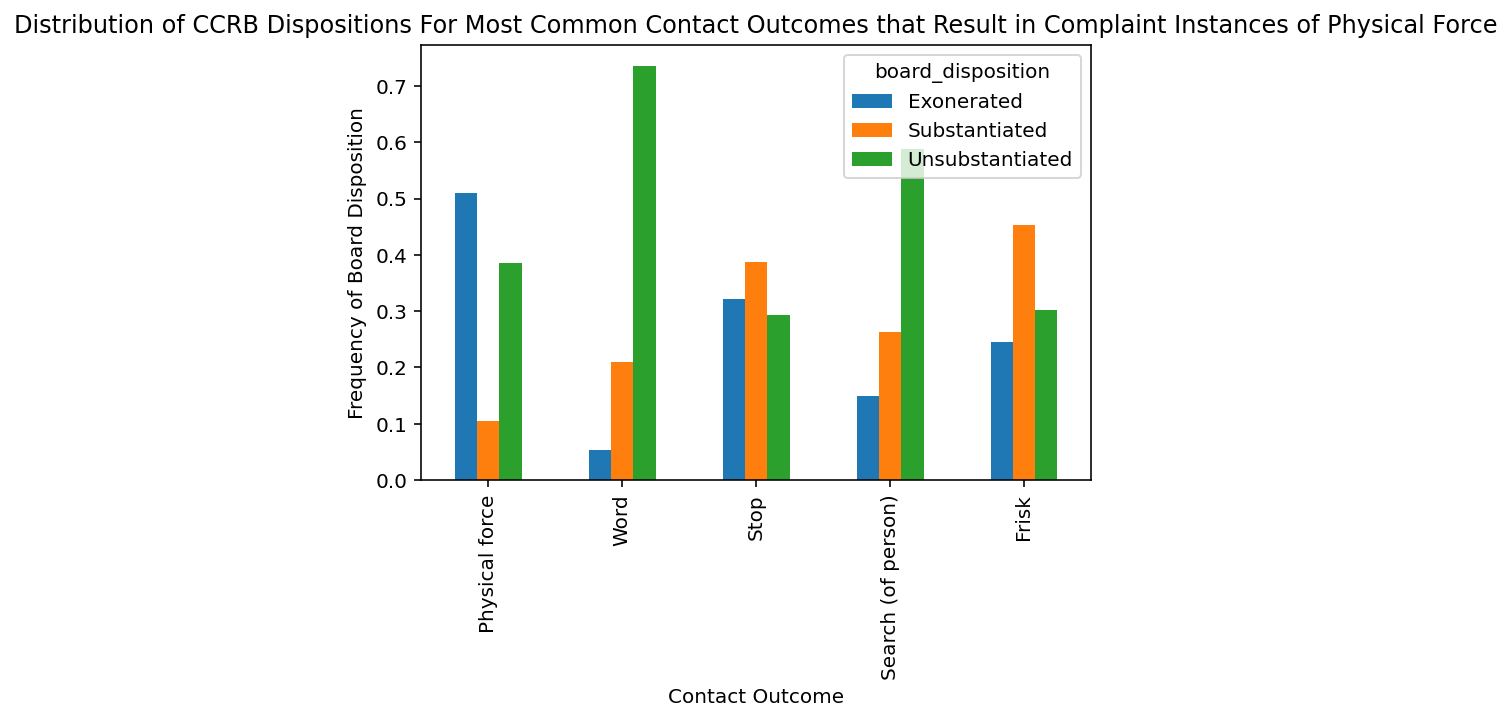

In [38]:
# found in previous eda 
top_5_allegations = ['Physical force', 'Word', 'Stop', 'Search (of person)', 'Frisk']

# STEP 1: "condense" the different levels of severity for substantiated cases
disposition_types = cc_with_description['board_disposition'].unique() # find all the dispos. types
substantiated = (
    disposition_types
    [~((disposition_types == 'Exonerated') | (disposition_types == 'Unsubstantiated'))]
) # finds all types of substantiated cases

# STEP 2: find the frequency of how the CCRB rules each type of complaint category
allegation_vs_board_dispos = pd.pivot_table(
    data=cc_with_description.replace(substantiated, 'Substantiated'), # all types of substantiated 
                                                                      # cases fall under 'Substantiated'
    index='allegation',
    values ='command_now',
    columns='board_disposition',
    aggfunc='count').fillna(0)

# STEP 3: (there's a lot of complaint categories) filters for the top 5 complaint categories
# and normalizes the frequency of the CCRB disposition with respect to the complaint category
top_allegation_vs_board_dispos = (
    allegation_vs_board_dispos
    .loc[top_5_allegations, :] # these were found during Univariate Analysis!                                                           
    .fillna(0)
    .transform(                                      
        lambda disposition_count: disposition_count / disposition_count.sum(), axis=1)
).fillna(0)

top_allegation_vs_board_dispos_plt = top_allegation_vs_board_dispos.plot(kind='bar')

add_labels(
    top_allegation_vs_board_dispos_plt,
    'Distribution of CCRB Dispositions For Most Common Contact Outcomes that Result in Complaint Instances of Physical Force',
    'Contact Outcome',
    'Frequency of Board Disposition'
)

Here, we can compare how the CCRB ruled the top 5 most common types of filed allegations.
- of allegations under Physical force, most investigations are Exonerated 
- of allegations under Word, most investigations are Unsubstantiated
- of allegations under Stop, most investigations are Substantiated
- of allegations under Search (of person), most investigations are Unsubstantiated
- of allegations under Frisk, most investigations are under Sunstantiated

*Implication:* The stark visual difference between distribution implies that `allegation` may be useful in predicting CCRB disposition

***Final Features yay!***

In [39]:
final_features = baseline_features + ['contact_reason', 'allegation'] # adding our new features to the test data

##### II. Tuning Hyperparameters via GridSearchCV 
Below, I tuned the hyperparameters of three classifiers:
- Logistic Regressor
- Decision Tree Classifier
- Random Forest Classifier  
  
I later used these best parameters & compared each classifier's performance on the same set of testing data to find the model which returned the highest recall.

*Step 2:* Model Comparison

In [43]:
one_hot = OneHotEncoder()
transformed_training_data = pd.DataFrame(
    one_hot.fit_transform(X_train_filled[final_features]).toarray()
)

In [71]:
# -----------------------
# LOGISTIC REGRESSOR
# -----------------------
log_hyperparams = {
    'C': [0.01,0.1,1,10,100], # how heavily weighted the training data is in tuning the parameters
    'max_iter': range(600, 800, 100) # number of iterations
} 
    
log_searcher = GridSearchCV(LogisticRegression(), log_hyperparams, cv=5, scoring='recall')

log_searcher.fit(transformed_training_data, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': range(600, 800, 100)},
             scoring='recall')

In [45]:
# -----------------------
# DECISION TREE CLASSIFIER
# -----------------------
dectree_hyperparams = {
    'max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18, None], 
    'min_samples_split': [2, 3, 5, 7, 10, 15, 20],
    'criterion': ['gini', 'entropy']
}

dectree_searcher = GridSearchCV(DecisionTreeClassifier(), dectree_hyperparams, cv=5, scoring='recall')

dectree_searcher.fit(transformed_training_data, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18, None],
                         'min_samples_split': [2, 3, 5, 7, 10, 15, 20]},
             scoring='recall')

In [46]:
# -----------------------
# RANDOM FOREST CLASSIFIER
# -----------------------
rf_hyperparams = {
    'n_estimators': [20, 60, 100, 140, 180],
    'max_depth': [2, 5, 7, 10, 15, 18, None],
    'bootstrap': [True, False]
}

rf_searcher = GridSearchCV(RandomForestClassifier(), rf_hyperparams, cv=5, scoring='recall')

rf_searcher.fit(transformed_training_data, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 5, 7, 10, 15, 18, None],
                         'n_estimators': [20, 60, 100, 140, 180]},
             scoring='recall')

In [72]:
print('best parameters:')
print(f'log regression: {log_searcher.best_params_}')
print(f'decision tree classifier:{dectree_searcher.best_params_}')
print(f'random forest:{rf_searcher.best_params_}')

best parameters:
log regression: {'C': 100, 'max_iter': 600}
decision tree classifier:{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
random forest:{'bootstrap': True, 'max_depth': None, 'n_estimators': 20}


##### III. Model Selection

In [130]:
def find_best(models):
    '''returns fitted model with highest recall'''
    max_recall = 0
    best_model = models[0]
    y_pred_final = np.array([])
    
    for model in models:
        # create a pipeline of the transformers and estimator
        pl = Pipeline([
            ('one-hot', OneHotEncoder(handle_unknown='ignore')),
            ('estimator', model)
        ])


        # fit the model to training data
        fitted_model = pl.fit(X_train_filled[final_features], y_train)

        # make predictions
        if isinstance(model, LogisticRegression):
            # find predictions at threshold 0.3
            y_probs = fitted_model.predict_proba(X_test[final_features])[: ,1]
            y_pred = np.array([1 if y_prob > 0.3 else 0 for y_prob in y_probs])
        else:
            y_pred = fitted_model.predict(X_test[final_features])
        
        # find recall
        recall = recall_score(y_test, y_pred)
        print(recall)
        
        # return fitted model with highest recall
        if recall > max_recall:
            max_recall = recall
            best_model = fitted_model
            y_pred_final = y_pred
        
    return best_model, y_pred_final

In [131]:
# fitted models with tuned hyperparams
models = [
    LogisticRegression(C=100, max_iter=600),
    DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2),
    RandomForestClassifier(bootstrap=True, max_depth=None, n_estimators=20)
]

In [132]:
best_model, y_pred_final = find_best(models)

0.5438908659549229
0.2912218268090154
0.2900355871886121


In [133]:
model_type = best_model.named_steps['estimator']
print(f'best model: {model_type}')
print(f'recall: {recall_score(y_test, y_pred_final)}')
print(f'precision: {precision_score(y_test, y_pred_final)}')
print(f'accuracy: {accuracy_score(y_test, y_pred_final)}')

best model: LogisticRegression(C=100, max_iter=600)
recall: 0.5438908659549229
precision: 0.4251274918868799
accuracy: 0.711764705882353


*Step 3:* Conclusion  

 After tuning the hyperparameters of three models and fitting them to the training data, the Random Forest Classifier performed best (with respect to recall) in predicting CCRB disposition when given the test dataset. 

### Fairness Analysis

Black complainants make up the largest category of complainants and are typically over-represented in cases of police brutality. Does the model perform differently for Black and non-Black complainants?

**Null Hypothesis:** The model is fair. Its recall for Black complainants and non-Black complainants are roughly the same, and any differences are due to random chance.

**Alternative Hypothesis:** The model is unfair. Its recall for Black complainants and non-Black complainants are not the same. 

In [134]:
# we will be assessing the recall for the testing set
results = X_test 
results['prediction'] = y_pred_final
results['tag'] = y_test

# groups: Black Complainants and non-Black Complainants
results['complainant_binary_ethnicity'] = (results.complainant_ethnicity == 'Black').replace({True: 'Black', False: 'Other'})

In [135]:
# grouping by Black and non-Black complainants to compare each 
# aggregate's recall score
obs_recalls = (
    results
    .groupby('complainant_binary_ethnicity')
    .apply(lambda x: metrics.recall_score(x['tag'], x['prediction']))
    .rename('recall')
    .to_frame()
)
obs_recalls

,recall
complainant_binary_ethnicity,
Black,0.544892
Other,0.542538


In [136]:
# observed difference in recall score between Black and non-Black complainants
obs_diff = obs_recalls.diff().iloc[-1]['recall']
obs_diff

-0.002353286613037575

In [137]:
diff_in_recall = []
for _ in range(100):
    s = (
        # filter for information necessary to calculate test data recall score
        results[['complainant_binary_ethnicity', 'prediction', 'tag']] 
        
        # randomly assign ethnicity (Black or Other) to each complaint
        .assign(is_black=results.complainant_binary_ethnicity.sample(frac=1.0, replace=False).reset_index(drop=True))
        
        # calculate difference in recall score between simulated Black and non-Black complainants
        .groupby('is_black')
        .apply(lambda x: metrics.recall_score(x['tag'], x['prediction']))
        .diff()
        .iloc[-1]
    )
    
    diff_in_recall.append(s)

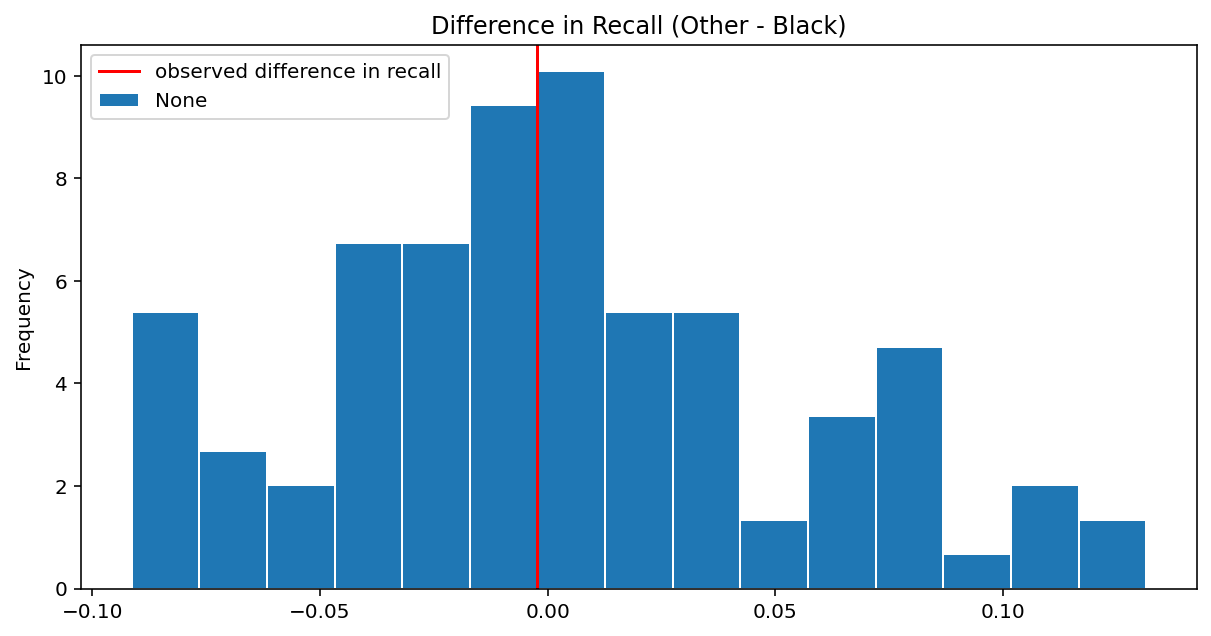

In [138]:
plt.figure(figsize=(10, 5))
pd.Series(diff_in_recall).plot(kind='hist', ec='w', density=True, bins=15, title='Difference in Recall (Other - Black)')
plt.axvline(x=obs_diff, color='red', label='observed difference in recall')
plt.legend(loc='upper left');

In [139]:
# p-value: probability of observed difference under the null hypothesis
# greater than alpha=0.05
np.mean(diff_in_recall >= obs_diff)

0.51